In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=788793d2ee02b79dfc3641769788ef75883a2c3189255d39b553c914f597558b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import os
import re
from pathlib import Path
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import *
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

Streaming output truncated to the last 5000 lines.
  inflating: 20_newsgroups/talk.politics.guns/54127  
  inflating: 20_newsgroups/talk.politics.guns/53302  
  inflating: 20_newsgroups/talk.politics.guns/54315  
  inflating: 20_newsgroups/talk.politics.guns/54771  
  inflating: 20_newsgroups/talk.politics.guns/54543  
  inflating: 20_newsgroups/talk.politics.guns/55233  
  inflating: 20_newsgroups/talk.politics.guns/55039  
  inflating: 20_newsgroups/talk.politics.guns/54749  
  inflating: 20_newsgroups/talk.politics.guns/55234  
  inflating: 20_newsgroups/talk.politics.guns/54782  
  inflating: 20_newsgroups/talk.politics.guns/54544  
  inflating: 20_newsgroups/talk.politics.guns/54312  
  inflating: 20_newsgroups/talk.politics.guns/54120  
  inflating: 20_newsgroups/talk.politics.guns/53305  
  inflating: 20_newsgroups/talk.politics.guns/54915  
  inflating: 20_newsgroups/talk.politics.guns/54129  
  inflating: 20_newsgroups/talk.politics.guns/54586  
  inflating: 20_newsgroups/talk

## Functions from lab

In [4]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [5]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [6]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [7]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [8]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [9]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [10]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9472744159462742
Test accuracy: 0.6776666666666666


In [11]:
X.shape


(19997, 1000)

In [12]:
X.head()

,the,to,of,a,and,I,is,in,that,AX,edu,it,for,you,on,be,com,s,have,are,not,with,t,The,this,1,as,or,was,From,Subject,ID,Message,Lines,Organization,they,but,by,can,In,...,INS,Smith,yourself,assume,worth,guy,wasn,box,involved,error,values,week,1993Apr5,move,taking,doubt,Eric,37,test,g,w,coming,05,action,1993Apr17,01,Thomas,United,uchicago,BATF,friend,HP,isc,present,shall,outside,weapons,cars,Summary,recently
20_newsgroups/rec.sport.hockey/53663,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_newsgroups/rec.sport.hockey/53849,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_newsgroups/rec.sport.hockey/54078,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_newsgroups/rec.sport.hockey/53971,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_newsgroups/rec.sport.hockey/53857,1,1,1,1,1,1,0,1,1,0,0,1,1,0,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Q1 (a)

### Feature set : 
- In the baseline algorithm, we have selected the most common 1000 words from the corpus as the feature set. All the features are single term features. As we can observe, most of the initial frequent words are prepositions and articles.

### The amount of data: 
- Total data points are 19997. For the baseline logistic regression classifier, we have selected 70% of the data as a train set and 30% of the data as a test set.

### Hyperparameters : 
- As we have used logistic regression as a classifier, there is one of the hyperparameters, the regularization parameter (C). We have used the C=1 value for the parameter.


### Q1 (b)

Modify the following function:

In [13]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
def new_clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub(r"\d+", "", new_text)       # removing numbers from the corpus 
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [15]:
def new_corpus_count_words(file_list):

    tokenizer = RegexpTokenizer(r'\w+')
    #sbStem = SnowballStemmer("english")
    #lrStem = LancasterStemmer()
    stop_words = set(stopwords.words('english')) 

    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = new_clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [ i.lower() for i in file_words]  # converting characters into lower case 
            file_words = [i for i in file_words if i not in stop_words] # removing stop words
            
            file_words = [ LancasterStemmer().stem(i) for i in file_words] # implementing stemmer 
    
            word_counter.update(file_words)
    return word_counter

In [16]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    news_cnt = new_corpus_count_words(file_list)  # new corpus count words 
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')

    stop_words = set(stopwords.words('english'))

    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = new_clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop_words]
            file_words = [ i.lower() for i in file_words]
            file_words = [ LancasterStemmer().stem(i) for i in file_words]

            df_rows.append([1 if word in file_words else 0 for word in word_list])  
    
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    y =  [get_target(get_topic_name(file_path)) for file_path in file_list]


    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [17]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)



# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9647067228691862
Test accuracy: 0.7391666666666666


- Train accuracy improved from 94.72% to 96.47% whereas test accuracy improved from 67.76% to 73.91%. We can observe that there is a significant improvement in the test accuracy. 

### Q1 (d)

Modify the partial code below

In [18]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here

    

    for split in range(num_tests):

      random_split =  np.random.randint(1,1000)

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_split)


      # train a logistic regression classifier
      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)

      # calculate train and test accuracy
      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)

      train_results.append(train_accuracy)
      test_results.append(test_accuracy)



    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [19]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9658355361863256
Train confidence interval over 10 random splits: [0.9648779395555301, 0.966793132817121]
Test mean accuracy over 10 random splits: 0.7414166666666666
Test confidence interval over 10 random splits: [0.7382381721164517, 0.7445951612168815]


- Average of the accuracies shows the mean of the accuracies with 10 random split of train-test data and the 95% confidence interval shows us that 95% chance that the interval contains the true mean of the population. 
- Yes, multiple iterations (here 10 iterations) convey more information than the single iteration because this provides us a range and we might as well get the maximum value of the chosen parameter and with the confidence interval we can also be certain that the mean of the chosen parameter lies in the interval. 
(With multiple iterations, we got to know that train and test accuracies can be improved with different train-test split as compared to Q1(c), the mean accuracies in Q1(e) are higher.) 

### Q1 (f)

Modify the partial code below

In [20]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here

    for split in range(num_tests):

      random_split =  np.random.randint(1,1000)

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_split)


      # train a logistic regression classifier
      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)

      cm = confusion_matrix(y_test, y_test_predict)

      cm_list.append(cm)
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = np.array(cm_list).sum(axis=0)

    # validate return type
    assert isinstance(combined_cm, np.ndarray), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

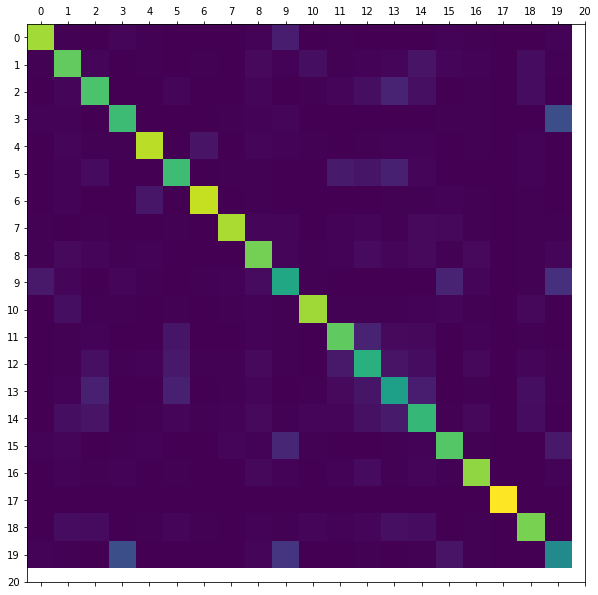

In [21]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [22]:
pd.DataFrame(cm10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2537,13,5,44,12,4,6,3,24,233,2,15,10,4,10,30,15,0,5,25
1,12,2240,53,6,22,10,14,8,74,27,114,23,29,42,159,35,27,0,102,22
2,0,47,2117,10,8,56,5,6,46,6,19,41,110,288,120,1,18,0,100,4
3,32,25,6,2018,11,1,5,12,32,35,8,6,11,5,4,20,21,0,6,714
4,4,39,17,12,2648,11,160,4,49,32,19,9,20,24,29,6,22,0,33,7
5,2,26,91,4,5,2034,0,17,23,3,10,213,164,265,51,4,11,0,29,3
6,2,27,8,1,174,4,2693,0,19,9,10,6,8,15,16,24,12,0,13,6
7,12,3,14,10,10,16,3,2574,40,39,10,26,42,21,70,60,22,0,12,17
8,17,80,42,22,31,10,5,9,2336,53,18,32,81,38,71,19,72,0,22,45
9,202,40,2,42,20,9,19,29,82,1760,20,8,8,8,10,289,43,0,13,409


In [23]:
topic_list =  ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']

print("3:", topic_list[3] , "  " ,"19:", topic_list[19])
print("9:",topic_list[9] , " ","19:", topic_list[19])
print("2:",topic_list[2] , " ","13:", topic_list[13])
print("9:",topic_list[9] , " ","15:", topic_list[15])


3: alt.atheism    19: talk.religion.misc
9: talk.politics.misc   19: talk.religion.misc
2: comp.sys.mac.hardware   13: comp.sys.ibm.pc.hardware
9: talk.politics.misc   15: talk.politics.guns


- Title 3 and 19 got the most confused in the above case. Topic 3 is of "atheism" whereas 19 is of "religion". They both talk about god. On the other hand topic 9(politics) and topic19(religion), topic2(mac hardware), and topic13(ibm hardware) and topic9(politics misc), and topic15(politics.guns) talk about the same subject.  It might be a case that classifier got confused in predicting topics as these topics are almost related or similar to each other.

## Q2

### Q2 (a)

Modify the partial code below

In [24]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # ......
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)         


        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

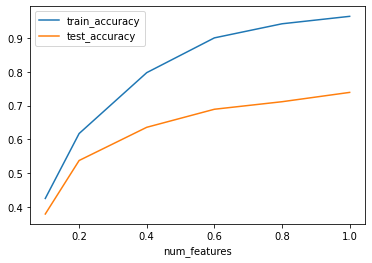

In [25]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

- we can observe that train and test accuracies are increasing with an increase in no. of features. The slop of the test and train accuracies is large during less no. of features but as no. of features increase the slop becomes less steep. This suggests that the increase in no. features after 60%, new features add less value compared to initial features. 

## Q3

### Q3 (a)

Modify the partial code below

In [26]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # ......
        clf = LogisticRegression(C= param).fit(X_train, y_train)

        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)  
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

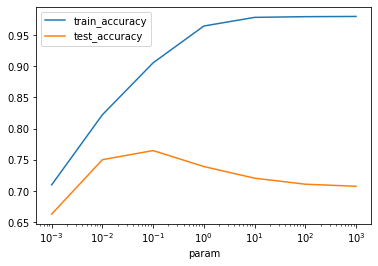

In [27]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

- The above graph shows that with an increase in the inverse regularization parameter, train accuracy increases, and after (C=10), it becomes almost constant whereas test accuracy increases till (C=0.1), and after that the graph starts declining. This suggests that overfitting has started after the C=0.1 value as training accuracy is high but testing accuracy decreases. 

## Q4

### Q4 (a)

Modify the partial code below

In [28]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below

    news_cnt = new_corpus_count_words(file_list)  # new corpus count words 
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')

    stop_words = set(stopwords.words('english'))

    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = new_clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop_words]
            file_words = [ i.lower() for i in file_words]
            file_words = [ LancasterStemmer().stem(i) for i in file_words]

            file_words_population = Counter(file_words) 

            df_rows.append([file_words_population[word] for word in word_list])  
    
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    y =  [get_target(get_topic_name(file_path)) for file_path in file_list]


    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [39]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 15)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9505513086137506
Train confidence interval over 10 random splits: [0.9473693284246077, 0.9537332888028934]
Test mean accuracy over 10 random splits: 0.746411111111111
Test confidence interval over 10 random splits: [0.743588259044912, 0.7492339631773101]


- Term Frequency encoding gives high mean accuracy than binary encoding.Term frequency encoding gives more weight to more frequent terms whereas binary encoding treats every term on an equal scale. In binary encoding, informative words as well as non informative words get same weight. This might affect the performance of the classifier. 

## Q5

### Q5 (a)

Modify the partial code below

In [30]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here


    for split in range(num_tests):

      random_split =  np.random.randint(1,1000)

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_split)


      # train a logistic regression classifier
      clf_nb =  MultinomialNB().fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf_nb.predict(X_train)
      y_test_predict = clf_nb.predict(X_test)

      # calculate train and test accuracy
      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)

      train_results.append(train_accuracy)
      test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [40]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7278488247481603
Train confidence interval over 10 random splits: [0.7265065361265138, 0.7291911133698067]
Test mean accuracy over 10 random splits: 0.6960166666666666
Test confidence interval over 10 random splits: [0.6920343426774657, 0.6999989906558676]


- Logistic regression worked better compared to the naive bayes method. This is because naive bayes assumes that all features are conditionally independent of each other. The data we are trying to classify is text data. In the text data, almost all words are dependent on each other. I believe, because of this reason naive bayes give less accuracy compared to logistic regression.

## Q6

### Q6 (a)

Modify the partial code below

In [32]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below

    news_cnt = new_corpus_count_words(file_list)  # new corpus count words 
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')

    stop_words = set(stopwords.words('english'))

    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = new_clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            file_words = [i for i in file_words if i not in stop_words]
            file_words = [ i.lower() for i in file_words]
            file_words = [ LancasterStemmer().stem(i) for i in file_words]

            df_rows.append([1 if word in file_words else 0 for word in word_list])  
    
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)

    y =  [1 if (get_topic_name(file_path)=="sci.med") else 0 for file_path in file_list]


    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [33]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9919768521826106
Train confidence interval over 10 random splits: [0.9916377981001214, 0.9923159062650997]
Test mean accuracy over 10 random splits: 0.9762333333333333
Test confidence interval over 10 random splits: [0.9748818698655423, 0.9775847968011243]


- Average of the accuracies shows the mean of the accuracies with 10 random split of train-test data and the 95% confidence interval shows us that 95% chance that the interval contains the true mean of the population. 
- Compared to multiclass logistic regression binary logistic regression gives more accuracy. This is obvious because we are converting data into skewed data. 

#Q7

##Q7(a)

use the following code cell to implement your feature encoding

In [34]:
def data_q7(file_list, num_words = 1000):

  vectorizer = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word',stop_words="english", 
                                      ngram_range=(1, 1), max_df=0.9, min_df=1, max_features=18000,  use_idf = True)
  

  all_data = []

  for file_path in all_files:
      with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
          file_data = file.read()
          file_data = new_clean_file_text(file_data)

          all_data.append(file_data)

# tf-idf encoding
  tf = vectorizer.fit_transform(all_data) 

  tf_array = tf.toarray() # converting to an array

    
    
  X = pd.DataFrame(tf_array, index=[str(f) for f in file_list])

  y =  [get_target(get_topic_name(file_path)) for file_path in file_list]



  
  #Please remember to put index for your dataframe as the file name
  #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
  
  # validate return types
  assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
  
  return X, y

##Q7(b)

Use the following code cell to implement your model

In [36]:
def build_model_q7():
  #write your code here, define your model
  MODELQ7= LogisticRegression(C=10)
  
  return MODELQ7

Code for evaluating p at k 

In [37]:
def calculate_average_precision_at_k(MODELQ7, all_files, training_files, testing_files,k=None):
  
  training_files = [str(f) for f in open(training_files,mode='r').read().splitlines()]
  testing_files = [str(f) for f in open(testing_files,mode='r').read().splitlines()]
  if k is None:
    k=len(testing_files)

  X, y = data_q7(all_files) 
  X['gt'] = y
  training = X.loc[training_files]
  X_train = training.loc[:,training.columns!='gt']
  y_train = training['gt'].values

  testing = X.loc[testing_files]
  X_test = testing.loc[:,testing.columns!='gt']
  y_test = testing['gt'].values

  MODELQ7.fit(X_train,y_train)
  y_pred = MODELQ7.predict(X_test)
  y_pred_prob = MODELQ7.predict_proba(X_test)
  confidences = np.max(y_pred_prob,axis=1)
  
  p_at_k = []
  rel_at_k = []
  confidence_order = np.argsort(confidences)
  for i in range(1,k+1):
    top_confidence = confidence_order[-i:]
    pred_top_i = y_pred[top_confidence]
    gt_top_i = np.array(y_test)[top_confidence]
    p_at_i = np.sum(pred_top_i == gt_top_i)/i
    rel_at_i = (pred_top_i[0] == gt_top_i[0])
    p_at_k.append(p_at_i)
    rel_at_k.append(rel_at_i)
  print('average precision at {} is {}'.format(k,np.dot(p_at_k,rel_at_k)/k))
  return np.dot(p_at_k,rel_at_k)/k

In [38]:
# Example usage:
m = calculate_average_precision_at_k(build_model_q7(), all_files, 'training_files_Q7.txt', 'testing_files_Q7.txt')

average precision at 4000 is 0.7567893542751205


##Q7(c)

### ANSWER (1):
- I have chosen tf-idf vectorization as feature encoding. The features I have used are the top 18000 tf-idf score words. 
- The reason for using tf-idf is, it balances the frequency of the term in the whole corpus as well as in a document. It does not give more weight to more frequent words but it gives more weight to those terms which are rare in documents.

### ANSWER (2):
- Logistic regression 


### ANSWER (3):
- I chose tf-idf because it gives a high score to those terms which are frequent with a small number of documents and a low score to those terms with less frequency or appears in many documents. 
- First 18000 highest tf-idf score features give more average precision.
- I have tried several other classifiers, for example, Gradientboost classifier and random forest classifier but logistic regression gives me the best average precision. 


### ANSWER (4):
- Final best AP = 0.7567

### DIFFERENT IMPLEMENTATION:

#### FEATURES: TF HIGH SCORE WORDS
#### ENCODING: BINARY 
#### CLASSIFIER : LOGISTIC REGRESSION WITH C=0.1
- NO. FEATURES - AP
- 2000 - 0.6520
- 2500 - 0.6621
- 3000 - 0.6722
- 3500 - 0.6794
- 4500 - 0.6910
- 8000 - 0.7085
- 10000 - 0.7113
- 15000 - 0.7159
- 20000 - 0.7184 

#### FEATURES: TF-IDF HIGH SCORE WORDS
#### ENCODING: BINARY 
#### CLASSIFIER : LOGISTIC REGRESSION WITH C=0.1
- NO. FEATURES - AP
- 10000 - 0.6579
- 18000 - 0.6811

#### FEATURES: TF-IDF HIGH SCORE WORDS
#### ENCODING: TF -IDF 
#### CLASSIFIER : LOGISTIC REGRESSION
- NO. FEATURES - AP
- 10000 - 0.7123
- 18000 - 0.7290
- 18000 - 0.7213 (BIGRAM)
- 18000 - 0.7510 (C=1)
- 18000 - 0.7566 (C=5)
- 18000 - 0.7567 (C=10) (-------HIGHEST--------)
- 18000 - 0.7564 (C=50)

#### FEATURES: TF-IDF HIGH SCORE WORDS
#### ENCODING: TF -IDF 
#### CLASSIFIER : GRADIENT BOOST
- NO. FEATURES - AP
- 18000 - 0.69

#### FEATURES: TF-IDF HIGH SCORE WORDS
#### ENCODING: TF -IDF 
#### CLASSIFIER : RANDOM FOREST
- NO. FEATURES - AP
- 18000 - 0.65

#### FEATURES: TF-IDF HIGH SCORE WORDS
#### ENCODING: TF -IDF 
#### CLASSIFIER : SVM
- NO. FEATURES - AP
- 18000 - 0.69



